In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report

In [29]:
DATASET_PATH = "/content/drive/MyDrive/dataset_nsfw_lite"

IMG_HEIGHT = 244
IMG_WIDTH = 244
BATCH_SIZE = 16
SEED = 42
EPOCHS_PHASE1 = 20
EPOCHS_PHASE2 = 25

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 1500 files belonging to 5 classes.
Using 1200 files for training.
Found 1500 files belonging to 5 classes.
Using 300 files for validation.
Classes: ['drawing', 'hentai', 'neutral', 'porn', 'sexy']


In [31]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [32]:
from tensorflow.keras import layers, models, regularizers

In [33]:
# ================= AUGMENTATION =================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


In [34]:
def res_block(x, filters, stride=1, reg=1e-4):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                                 kernel_regularizer=regularizers.l2(reg))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ================= MODEL =================
def build_resnet(img_size=244, num_classes=5, reg=1e-4):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Augmentation only on training
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 7, strides=2, padding='same',
                      kernel_regularizer=regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual stages (lite)
    x = res_block(x, 32, reg=reg)
    x = res_block(x, 64, stride=2, reg=reg)
    x = res_block(x, 128, stride=2, reg=reg)
    x = res_block(x, 256, stride=2, reg=reg)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(reg))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ================= BUILD =================
model = build_resnet(IMG_HEIGHT, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 244, 244,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 244, 244,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 122, 122,  │      4,736 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 122, 122,  │        128 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 122, 122,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 61, 61,    │          0 │ re_lu_26[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 61, 61,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        128 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 61, 61,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 61, 61,    │      9,248 │ re_lu_27[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        128 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 61, 61,    │          0 │ add_12[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 31, 31,    │     18,496 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 31, 31,    │          0 │ batch_normalizat

 Total params: 1,301,637 (4.97 MB)

 Trainable params: 1,298,757 (4.95 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [36]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)


In [37]:
# ================= TRAIN PHASE 1 =================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=[early_stop]
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.2909 - loss: 1.7690 - val_accuracy: 0.2633 - val_loss: 1.7837
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.4237 - loss: 1.5162 - val_accuracy: 0.2933 - val_loss: 1.9938
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.4551 - loss: 1.4082 - val_accuracy: 0.2767 - val_loss: 2.2486
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.5165 - loss: 1.3190 - val_accuracy: 0.3267 - val_loss: 2.4699
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.5023 - loss: 1.3253 - val_accuracy: 0.3733 - val_loss: 1.8905
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.5478 - loss: 1.2141 - val_accuracy: 0.3900 - val_loss: 2.0357
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.5471 - loss: 1.1925 - val_accuracy: 0.4500 - val_loss: 1.5069
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.5524 - loss: 1.2009 - val_accura

In [38]:
# ================= TRAIN PHASE 2 =================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=[early_stop]
)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.5815 - loss: 1.1610 - val_accuracy: 0.5567 - val_loss: 1.1489
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.5938 - loss: 1.1206 - val_accuracy: 0.5467 - val_loss: 1.1363
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.5801 - loss: 1.1357 - val_accuracy: 0.5600 - val_loss: 1.1353
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.6296 - loss: 1.0452 - val_accuracy: 0.5600 - val_loss: 1.1471
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.6256 - loss: 1.1069 - val_accuracy: 0.5500 - val_loss: 1.1832
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.6045 - loss: 1.0772 - val_accuracy: 0.5700 - val_loss: 1.1325
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6309 - loss: 1.0574 - val_accuracy: 0.5733 - val_loss: 1.1325
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.6200 - loss: 1.1057 - val_accurac

In [40]:
# ============================
# TRAINING PHASE 3 (ULTRA FINE-TUNING)
# ============================

# Learning rate super kecil (micro update)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_PHASE3 = 50

history_phase3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE3,
    callbacks=[early_stop]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.6326 - loss: 1.0005 - val_accuracy: 0.5600 - val_loss: 1.1388
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.6538 - loss: 0.9871 - val_accuracy: 0.5567 - val_loss: 1.1452
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.6496 - loss: 0.9918 - val_accuracy: 0.5800 - val_loss: 1.1334
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.6750 - loss: 0.9878 - val_accuracy: 0.5700 - val_loss: 1.1398
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.6718 - loss: 0.9851 - val_accuracy: 0.5800 - val_loss: 1.1506
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.6615 - loss: 0.9669 - val_accuracy: 0.5700 - val_loss: 1.1218
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.6627 - loss: 0.9804 - val_accuracy: 0.5833 - val_loss: 1.1326
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.6853 - loss: 0.9660 - val_accura

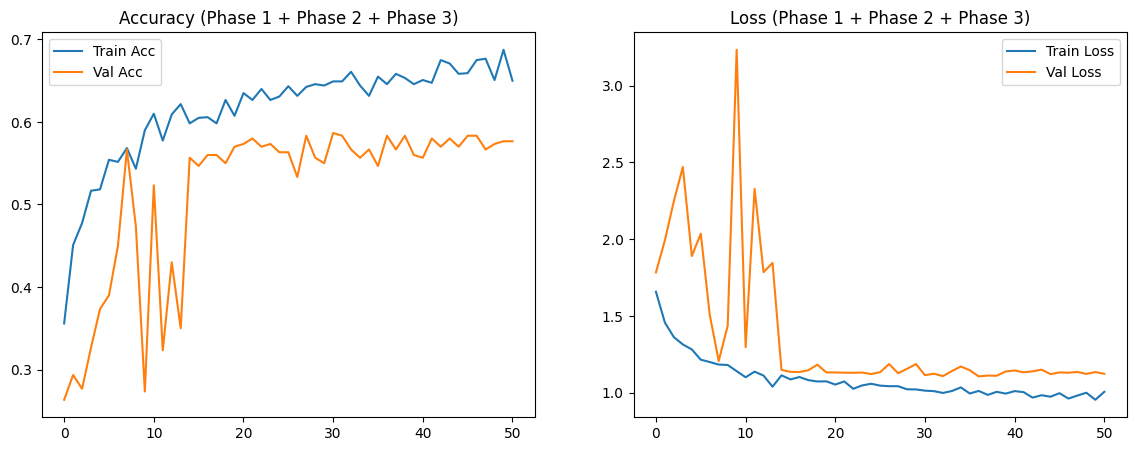

In [41]:
# ============================
# COMBINED HISTORY PLOT (PHASE 1 + 2 + 3)
# ============================

acc = (
    history.history['accuracy'] +
    history_finetune.history['accuracy'] +
    history_phase3.history['accuracy']
)

val_acc = (
    history.history['val_accuracy'] +
    history_finetune.history['val_accuracy'] +
    history_phase3.history['val_accuracy']
)

loss = (
    history.history['loss'] +
    history_finetune.history['loss'] +
    history_phase3.history['loss']
)

val_loss = (
    history.history['val_loss'] +
    history_finetune.history['val_loss'] +
    history_phase3.history['val_loss']
)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy (Phase 1 + Phase 2 + Phase 3)')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Phase 1 + Phase 2 + Phase 3)')

plt.show()

In [42]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_class = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_class)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
              precision    recall  f1-score   support

     drawing       0.43      0.58      0.50        57
      hentai       0.67      0.72      0.69        50
     neutral       0.47      0.47      0.47        64
        porn       0.77      0.69      0.73        58
      